Dataset Preparation

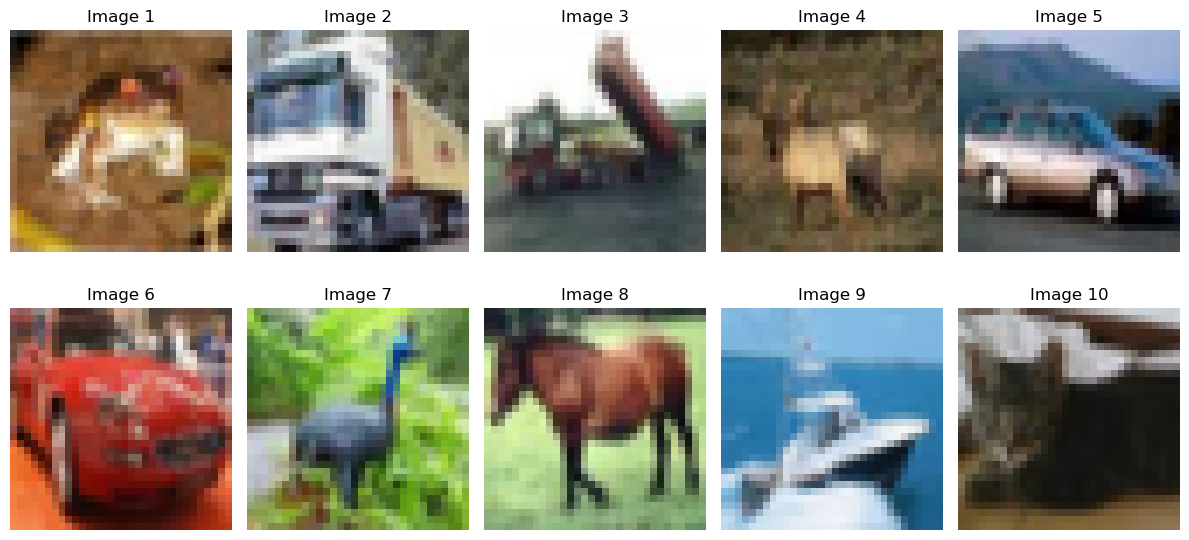

X_train # before split:  (50000, 32, 32, 3)
---
X_train # after split:  (40000, 32, 32, 3)
Y_train # after split: (40000, 1)
X_val # after split:  (10000, 32, 32, 3)
Y_val # after split: (10000, 1)
---
Y_train[1]:  [8]
Y_train shape:  (40000, 1)
Y_train[1]:  [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
Y_train shape:  (40000, 10)
---


In [12]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from keras.datasets import cifar10
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder


(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()


# train_images 중 첫 번째부터 열 번째까지 이미지 출력
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.ravel()

for i in range(10):
    axes[i].imshow(X_train[i])
    axes[i].axis('off')
    axes[i].set_title(f"Image {i+1}")

plt.tight_layout()
plt.show()

# print("X_train[0]: ", X_train[0])
X_train = X_train.astype('float32')
# print("X_train[0]: ", X_train[0])

X_test = X_test.astype('float32')
X_train /= 255.0
X_test /= 255.0


print("X_train # before split: ", X_train.shape)
print("---")

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.2,shuffle = True)
print("X_train # after split: ", X_train.shape)
print("Y_train # after split:", Y_train.shape)
print("X_val # after split: ", X_val.shape)
print("Y_val # after split:", Y_val.shape)
print("---")

encoder = OneHotEncoder()
encoder.fit(Y_train)

print("Y_train[1]: ", Y_train[1])
print("Y_train shape: ", Y_train.shape)
Y_train = encoder.transform(Y_train).toarray()
print("Y_train[1]: ", Y_train[1])
print("Y_train shape: ", Y_train.shape)
print("---")

# print("Y_test[1]: ", Y_test[1])
Y_test = encoder.transform(Y_test).toarray()
# print("Y_test[1]: ", Y_test[1])

Y_val =  encoder.transform(Y_val).toarray()


Create MobileNet

In [13]:
import numpy as np
import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer

from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense


class ConvLayer(Layer):
    def __init__(self, filters, k_conv, s_conv, k_depthconv=None, s_depthconv=None, depthwise=True):
        super(ConvLayer, self).__init__()
        self.simple_conv = Conv2D(filters=filters, kernel_size=k_conv, strides=s_conv, padding='same')
        self.bn1 = BatchNormalization()
        self.act1 = Activation('relu')
        
        self.depthwise = depthwise
        if self.depthwise:
            self.depth_conv = DepthwiseConv2D(depth_multiplier=1, kernel_size=k_depthconv, strides=s_depthconv, padding='same')
            self.bn2 = BatchNormalization()
            self.act2 = Activation('relu')
        
    def call(self, x):
        x = self.simple_conv(x)
        x = self.bn1(x)
        x = self.act1(x)
        # print(x.shape)

        if self.depthwise:
            x = self.depth_conv(x)
            x = self.bn2(x)
            x = self.act2(x)
            # print(x.shape)
        
        # print('-----')

        return x
    

class MobileNet(Model):
    def __init__(self, num_classes):
        super(MobileNet, self).__init__()
        
        self.conv1 = ConvLayer(filters=32, k_conv=3, s_conv=2, k_depthconv=3, s_depthconv=1)
        self.conv2 = ConvLayer(filters=64, k_conv=1, s_conv=1, k_depthconv=3, s_depthconv=2)
        self.conv3 = ConvLayer(filters=128, k_conv=1, s_conv=1, k_depthconv=3, s_depthconv=1)
        self.conv4 = ConvLayer(filters=128, k_conv=1, s_conv=1, k_depthconv=3, s_depthconv=2)
        self.conv5 = ConvLayer(filters=256, k_conv=1, s_conv=1, k_depthconv=3, s_depthconv=1)
        self.conv6 = ConvLayer(filters=256, k_conv=1, s_conv=1, depthwise=False)
        
        self.avg_pool = GlobalAveragePooling2D()
        self.fc = Dense(num_classes, activation='softmax')

    def call(self, input):
        # print("input: ", input.shape)
        x = self.conv1(input)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)

        x = self.avg_pool(x)
        # print(x.shape)
        x = self.fc(x)
        # print(x.shape)
        
        return x


# x = tf.random.normal(shape=(1, 32, 32, 3))
# model = MobileNet(num_classes=10)
# predictions = model(x)

Training

In [14]:
model = MobileNet(num_classes=10)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, Y_train, batch_size=256, epochs=10, validation_data=(X_val, Y_val))

Epoch 1/10
157/157 [==============================] - 31s 181ms/step - loss: 1.5901 - accuracy: 0.4184 - val_loss: 2.6708 - val_accuracy: 0.1005
Epoch 2/10
157/157 [==============================] - 26s 165ms/step - loss: 1.2143 - accuracy: 0.5653 - val_loss: 3.0130 - val_accuracy: 0.0961
Epoch 3/10
157/157 [==============================] - 26s 164ms/step - loss: 1.0533 - accuracy: 0.6228 - val_loss: 2.8322 - val_accuracy: 0.1238
Epoch 4/10
157/157 [==============================] - 26s 164ms/step - loss: 0.9373 - accuracy: 0.6672 - val_loss: 1.2718 - val_accuracy: 0.5449
Epoch 5/10
157/157 [==============================] - 26s 164ms/step - loss: 0.8398 - accuracy: 0.7029 - val_loss: 1.1955 - val_accuracy: 0.5878
Epoch 6/10
157/157 [==============================] - 26s 164ms/step - loss: 0.7608 - accuracy: 0.7317 - val_loss: 1.1365 - val_accuracy: 0.6117
Epoch 7/10
157/157 [==============================] - 26s 164ms/step - loss: 0.6957 - accuracy: 0.7554 - val_loss: 1.2658 - val_ac

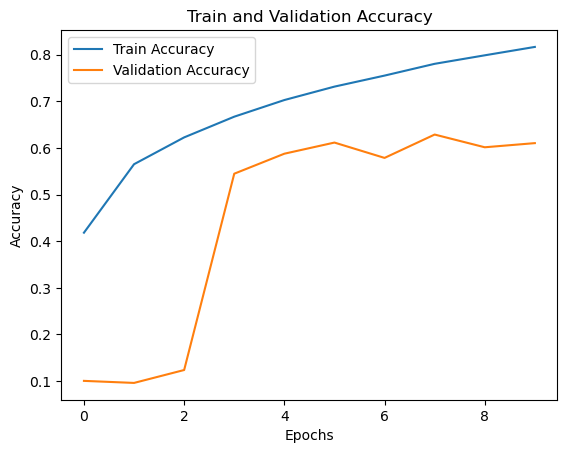

Test Accuracy: 0.6082000136375427


In [15]:
# Train 및 Validation Accuracy 그래프
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Train and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train Accuracy', 'Validation Accuracy'])
plt.show()

# Test 데이터셋에서의 Accuracy 측정
test_loss, test_accuracy = model.evaluate(X_test, Y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy}")